# **CÀI ĐẶT**

up load file simulator.zip và sửa lại file config.json cho phù hợp với mạng

In [ ]:
cd "/content"

/content


In [ ]:
!git clone https://github.com/phuongtrau/SNN_TeaLearning_Training.git

In [ ]:
cd "/content/SNN_TeaLearning_Training/tealayers/tealayer1.0/tealayers/3_class"

/content/SNN_TeaLearning_Training/tealayers/tealayer1.0/tealayers/3_class


In [ ]:
!pip install tensorflow==1.15
!pip install bitstring
!pip install keras==2.3.0

# **PYTHON**

**Import thư viện**

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import operator
import functools
import math

import tensorflow as tf
import numpy as np
from keras import backend as K
from keras import Model
from keras.engine.topology import Layer
from keras import initializers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Activation, Input, Lambda, Concatenate,Average
from keras.datasets import mnist,fashion_mnist
from keras.optimizers import Adam
from keras.utils import to_categorical
import sys
sys.path.append("../../../../rancutils/rancutils")
from teaconversion import create_cores,create_packets,get_connections_and_biases
from packet import Packet
sys.path.append("../")
from additivepooling import AdditivePooling
import helper
from tea import Tea
from sklearn.utils import shuffle
import cv2

Using TensorFlow backend.


**Khởi tạo mạng**

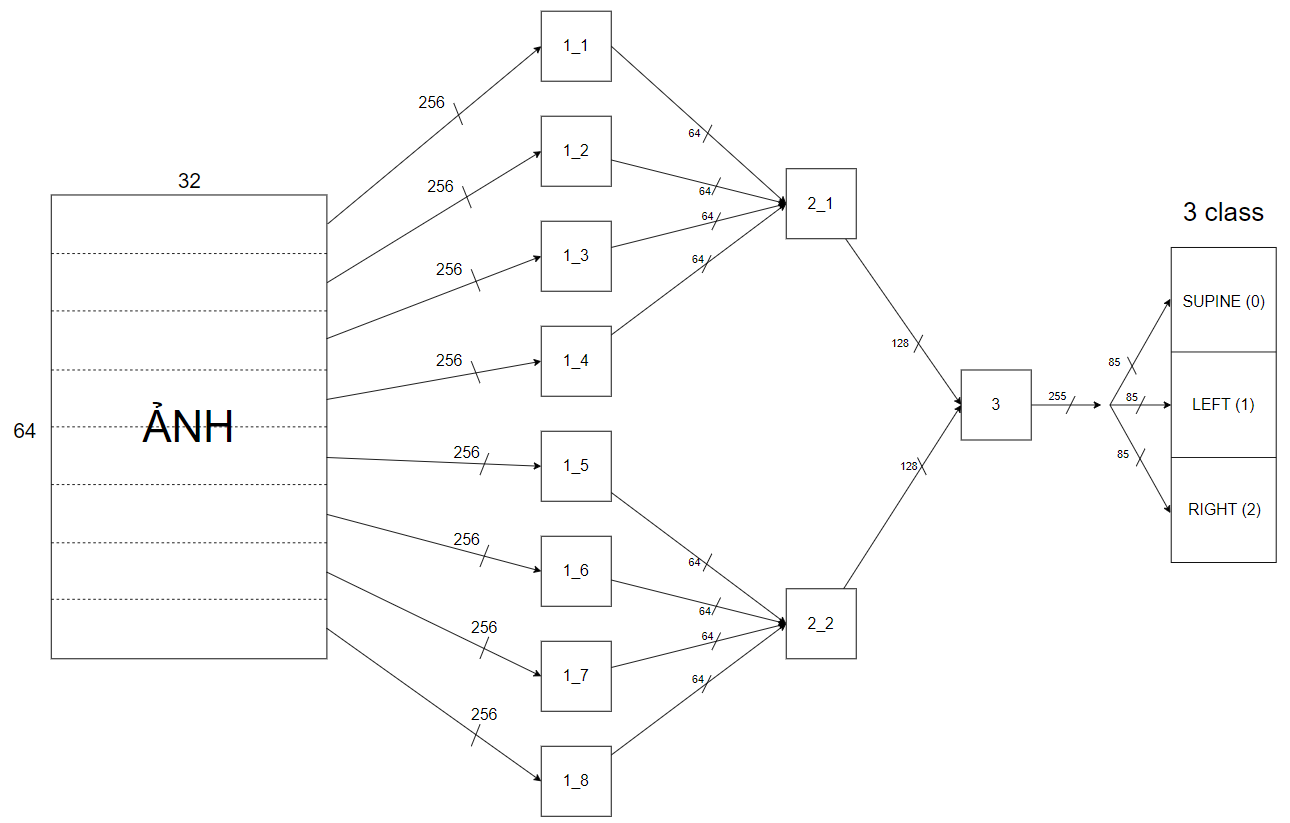

In [ ]:
# Ảnh đầu vào có kích thước 64x32
inputs = Input(shape=(64, 32,))
flattened_inputs = Flatten()(inputs)

# Trải phẳng bức ảnh, đưa lần lượt 256 pixel của ảnh vào 8 core đầu vào (chia bức ảnh thành 8 phần)
x1_1  = Lambda(lambda x : x[:,     :256 ])(flattened_inputs)
x2_1  = Lambda(lambda x : x[:, 256 :512 ])(flattened_inputs)
x3_1  = Lambda(lambda x : x[:, 512 :768 ])(flattened_inputs)
x4_1  = Lambda(lambda x : x[:, 768 :1024])(flattened_inputs)
x5_1  = Lambda(lambda x : x[:, 1024:1280])(flattened_inputs)
x6_1  = Lambda(lambda x : x[:, 1280:1536])(flattened_inputs)
x7_1  = Lambda(lambda x : x[:, 1536:1792])(flattened_inputs)
x8_1  = Lambda(lambda x : x[:, 1792:    ])(flattened_inputs)
# 64 neuron được sử dụng trong mỗi 8 core đầu vào này
x1_1  = Tea(64, name='tea_1_1')(x1_1)
x1_2  = Tea(64, name='tea_1_2')(x2_1)
x1_3  = Tea(64, name='tea_1_3')(x3_1)
x1_4  = Tea(64, name='tea_1_4')(x4_1)
x1_5  = Tea(64, name='tea_1_5')(x5_1)
x1_6  = Tea(64, name='tea_1_6')(x6_1)
x1_7  = Tea(64, name='tea_1_7')(x7_1)
x1_8  = Tea(64, name='tea_1_8')(x8_1)

# Cứ mỗi cụm 4 core lại được ghép nối với một core ở layer tiếp theo => ở layer 2 có 2 core
x2_1 = Concatenate(axis=1)([x1_1,x1_2,x1_3,x1_4])
x2_2 = Concatenate(axis=1)([x1_5,x1_6,x1_7,x1_8])
# Có 128 neuron được sử dụng trong mỗi core ở layer thứ 2 này
x2_1 = Tea(128, name='tea_2_1')(x2_1)
x2_2 = Tea(128, name='tea_2_2')(x2_2)

# 2 core ở layer thứ 2 được ghép lại và nối vào core ở layer cuối cùng
x_out = Concatenate(axis=1)([x2_1, x2_2])
# core này sử dụng 255 neuron để phân biệt 3 class (mỗi class sẽ có 85 neuron vote)
x_out = Tea(255, name='tea_3')(x_out)
x_out = AdditivePooling(3)(x_out)

**Load dataset**

In [ ]:
exp_i_data = helper.load_exp_i_short("../../dataset/experiment-i")

datasets = {"Base":exp_i_data}
train_data = helper.Mat_Dataset(datasets,["Base"],["S1","S2","S3","S4","S5","S6","S7","S8","S9"])
test_data = helper.Mat_Dataset(datasets,["Base"],["S10","S11","S12","S13"])

**Tiền xử lý data**

In [ ]:
#!mkdir "/content/image_testt"

In [ ]:
# Histogram equalize
for i in range(len(train_data.samples)):
    train_data.samples[i] = cv2.equalizeHist(train_data.samples[i])

# # from google.colab.patches import cv2_imshow
# d = 1185
# cv2_imshow(thunghiem.samples[d])
# print(thunghiem.labels[d])

# for i in range(10):
#     cv2.imwrite("/content/image_test/img_raw_{}.jpg".format(i),test_data.samples[i*200])

for i in range(len(test_data.samples)):
    test_data.samples[i] = cv2.equalizeHist(test_data.samples[i])
    
# for i in range(10):
#     cv2.imwrite("/content/image_test/img_raw_after_{}.jpg".format(i),test_data.samples[i*200])

In [ ]:
x_train = train_data.samples.astype('float32')
x_test = test_data.samples.astype('float32')

x_train /= 255
x_test /= 255

y_train = to_categorical(train_data.labels, 3)
y_test = to_categorical(test_data.labels, 3)

(x_train,y_train) = shuffle(x_train,y_train)
(x_test,y_test) = shuffle(x_test,y_test)

**Training model**

In [ ]:
predictions = Activation('softmax')(x_out)

model = Model(inputs=inputs, outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=64,
          epochs=15,
          verbose=1,
          validation_split=0.2)

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

**Generate network**

In [ ]:
cd "/content/SNN_TeaLearning_Training/tealayers/tealayer1.0/tealayers/3_class"

/content/SNN_TeaLearning_Training/tealayers/tealayer1.0/tealayers/3_class


In [ ]:
from output_bus import OutputBus
from serialization import save as sim_save


x_test_flat = x_test.reshape((5219, 2048))
partitioned_packets = []

# Số lượng ảnh cần test (max 5219 ảnh)
num_test_samples = 1

# Tạo các core bằng hàm create_cores(), sử dụng 2 layer (1 layer 4 core và 1 layer 1 core), sử dụng absolute reset mode: neuron_reset_type=0
cores_sim = create_cores(model, 3, neuron_reset_type=0) 
# Partition the packets into groups as they will be fed into each of the input cores
partitioned_packets.append(x_test_flat[:num_test_samples, :256])
partitioned_packets.append(x_test_flat[:num_test_samples, 256 :512])
partitioned_packets.append(x_test_flat[:num_test_samples, 512 :768])
partitioned_packets.append(x_test_flat[:num_test_samples, 768 :1024])
partitioned_packets.append(x_test_flat[:num_test_samples, 1024:1280])
partitioned_packets.append(x_test_flat[:num_test_samples, 1280:1536])
partitioned_packets.append(x_test_flat[:num_test_samples, 1536:1792])
partitioned_packets.append(x_test_flat[:num_test_samples, 1792:    ])
# Tạo packet bằng hàm create_packets()
packets_sim = create_packets(partitioned_packets)
# Tạo output_bus bằng hàm OutputBus(coordinate, num_outputs)
output_bus_sim = OutputBus((0, 3), num_outputs=255)

# Đây chính là file đầu vào cho giả lập kiến trúc RANC bằng code C++
sim_save("/content/input.json", cores_sim, packets_sim, output_bus_sim, indent=2)

# Lưu lại đầu ra của tensorflow predictions và correct labels để tý làm cross validation
predict = model.predict(x_test[:num_test_samples,:])
idx = []
for i in predict:
  idx.append(np.argmax(i))
test_predictions = to_categorical(idx)
np.save("/content/tf_preds.txt", test_predictions)
np.save("/content/correct_preds.txt", y_test[:num_test_samples,:])

**Lưu file mem**

In [ ]:
from emulation import output_for_streaming, output_for_testbench

In [ ]:
output_for_streaming(cores_sim,max_xy=(11,1),output_path="/content/11_cores_mem")

In [ ]:
!zip -r /content/11_cores_mem.zip /content/11_cores_mem

In [ ]:
from google.colab import files
files.download("/content/11_cores_mem.zip")

**Lưu đầu vào, đầu ra chuẩn**

In [ ]:
output_for_testbench(packets_sim,
                         y_test[:num_test_samples,:],
                         output_path='/content/',
                         input_filename='tb_input.txt',
                         correct_filename='tb_correct.txt',
                         num_inputs_filename='tb_num_inputs.txt',
                         num_outputs_filename='tb_num_outputs.txt',
                         max_packet_xy=(512, 512),
                         num_axons=256,
                         num_ticks=16,
                         num_outputs=256)

# **C++**

**Compile code**

In [ ]:
cd "/content/"

/content


In [ ]:
!unzip "simulator.zip"

In [ ]:
cd "./simulator/"

/content/simulator


In [ ]:
!mkdir build

In [ ]:
cd build

/content/simulator/build


In [ ]:
!cmake ".."
!make

**Chạy code**

Muốn chạy với x ảnh thì số tick là x + 3, do trễ 3 tick từ 3 layer

In [ ]:
!/content/simulator/build/ranc_sim -i /content/input.json -o /content/simulator_output.txt -c /content/simulator/config.json 4 -t trace.txt

[ERROR] Error parsing input: Neuron destination_axon is >= num_axons.


# **So sánh**

Trước khi so sánh, xóa 3 dòng đầu của "simulator_output.txt", do mạng có 3 layer nên sẽ bị trễ 3 tick

In [ ]:
cd "/content/SNN_TeaLearning_Training/rancutils/rancutils"

In [ ]:
from simulator import collect_classifications_from_simulator
tf_output = np.load("/content/tf_preds.txt"+".npy")
correct_output = np.load("/content/correct_preds.txt"+".npy")
simulator_output = collect_classifications_from_simulator("/content/simulator_output.txt", num_classes=3)

tf_output_flat = np.array([0] * tf_output.shape[0])
for i in range(tf_output.shape[0]):
    output_i = tf_output[i, :]
    decision = np.where(output_i == max(output_i))[0]
    if len(decision) > 1:
        decision = decision[0]
    tf_output_flat[i] = decision
tf_output = tf_output_flat
    
correct_output_flat = np.array([0] * correct_output.shape[0])
for i in range(correct_output.shape[0]):
    output_i = correct_output[i, :]
    decision = np.where(output_i == max(output_i))[0]
    if len(decision) > 1:
        decision = decision[0]
    correct_output_flat[i] = decision
correct_output = correct_output_flat

if all(tf_output == simulator_output):
    print("Tensorflow output matches simulator output exactly!")
    print(f"Testing accuracy against known class labels is {(len(np.where(tf_output == correct_output[:len(tf_output)])[0]) / len(tf_output)) * 100}%")
else:
    print("There are differences between Tensorflow and the simulator...")
    print(f"Differences are in indices {np.where(tf_output != simulator_output)}")
    print(f"Tensorflow thought the classes were {tf_output[np.where(tf_output != simulator_output)]}")
    print(f"The simulator thought the classes were {simulator_output[np.where(tf_output != simulator_output)]}")
    print(f"The correct classes were {correct_output[np.where(tf_output != simulator_output)]}")

Tensorflow output matches simulator output exactly!
Testing accuracy against known class labels is 100.0%
